# Classification Notebook
## XGBoost

This is the main notebook used to create my models for detecting harmful comments in a corpus of comments from r/soccer subreddit. 

Plan of action: 
1. Load and Explore the Data
    - **Statistics:** Understand the dataset dimensions, data types and missing values
    - **Class Distribution:** Determine the extent of imbalance in my dataset
    - **Text Exploration:** Check for common words, slang and noise in the text
2. Data Preprocessing
    - **Cleaning Text:** Remove stopwords, non-alphabetic characters, URLS
    - **Feature Engineering:**
        - TF-IDF
        - Word2Vec
        - Lexical Features (Count of words, sentence length, punctuation usage)
        - Topic Modeling
3. Split the Data
4. Initial Model Training with Tuning
    - XGBoost
5. Advanced Feature Engineering
    - Explore if combination of words or features increase predicitons performance
    - N-grams 
6. Address the Imbalance
    - Oversampling minority class (SMOTE)
    - Undersampling the majority class
    - Stratified KFold

***

In [ ]:
# In order to import required libraries and tools, you may need to run this
# cell in order to install all dependencies
!pip install pandas matplotlib wordcloud numpy seaborn nltk scikit-learn gensim scipy xgboost imbalanced-learn
import nltk
nltk.download('stopwords')

In [9]:
# Imports for Data Exploration
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np
import seaborn as sns

# Imports for Data Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from scipy.sparse import hstack, csr_matrix

# Imports for Data Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Imports for Models
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Imports for Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold


# Imports for Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Loading the dataset
data_path = 'data.csv'
data = pd.read_csv(data_path)

In [3]:
# Looking at the head of dataframe
data.head()

,id,comment,score,sentiment
0,1,"What happened to sevilla, seriously?",1,0
1,2,is tom huddlestone right or left footed?,1,0
2,3,How highly rated was Deivid Washington at Sant...,1,0
3,4,Yeah I thought you guys would go for more high...,1,0
4,5,Never judge a player based on such limited gam...,1,0


In [4]:
dimension = data.shape
data_types = data.dtypes
missing_values = data.isnull().sum()

dimension, data_types, missing_values

((19282, 4),
 id            int64
 comment      object
 score         int64
 sentiment     int64
 dtype: object,
 id           0
 comment      0
 score        0
 sentiment    0
 dtype: int64)

## Summary of our statistics

**Dimensions** - The dataset contains 19,282 rows with 4 columns
**Data Types** - id, score and sentiment are a floating point number, comment is a string
**Missing values** - 0 missing values
***

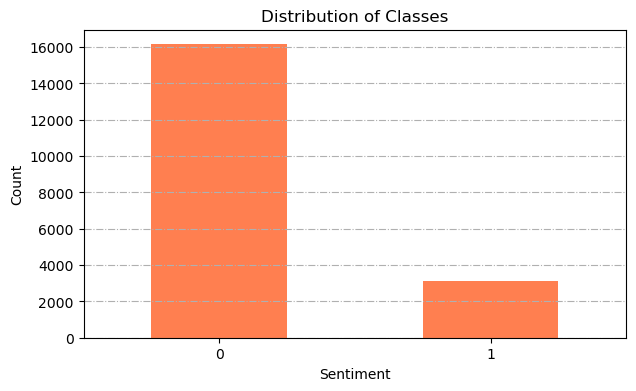

sentiment
0    16151
1     3131
Name: count, dtype: int64

In [5]:
# Class Distribution in the dataset
class_distribution = data['sentiment'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(7, 4))
class_distribution.plot(kind='bar', color='coral')
plt.title('Distribution of Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='dashdot')
plt.show()

class_distribution

This shows a significant imbalance in our dataset with 16,151 comments being non-harmful and 3,131 comments being harmful.
***

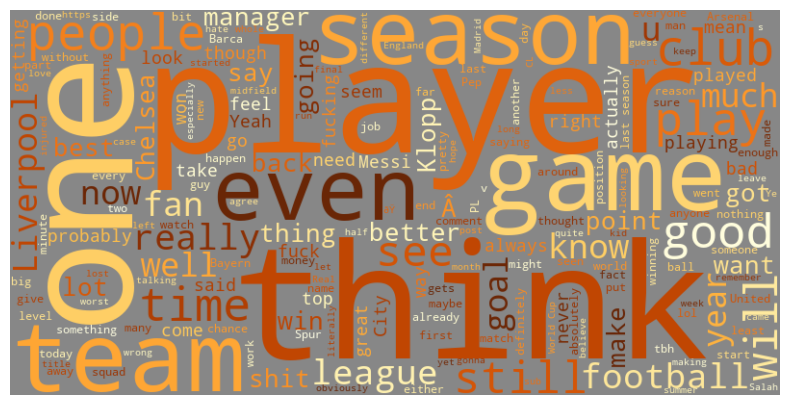

In [6]:
# Combine comments into a single string
all_comments = ' '.join(data['comment'].astype(str))

# Word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='#878787', colormap='YlOrBr').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
# Clean and Tokenize text
def tokenize(text):
    tokens = re.findall(r"\b\w[\w']*\b", text.lower())
    return tokens

# Tokenize comments
tokens = [tokenize(comment) for comment in data['comment']]
all_tokens = [token for sublist in tokens for token in sublist]
token_counts = Counter(all_tokens)

# Display the most common words
most_common_words = token_counts.most_common(20)
print("Most common words:", most_common_words)

Most common words: [('the', 21234), ('a', 13466), ('to', 11737), ('and', 10682), ('of', 8593), ('in', 8457), ('i', 7488), ('is', 7254), ('that', 6475), ('for', 5791), ('he', 5417), ('it', 5372), ('but', 4678), ('you', 4266), ('was', 3945), ('be', 3663), ('not', 3499), ('on', 3333), ('with', 3185), ('have', 3138)]


## Analysis of Common Words

The most common words in the dataset are typical stop words such as "the", "a", "to" and "and". These do not provide the models into much insight as to whether the comments are harmful or not. During my data preprocessing it will be therefore worth removing these stopwords. 
***
# Data Preprocessing

In [10]:
# Basic Text Cleaning
def clean_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)#urls
    text = re.sub(r'[^\w\s]', '', text)#non-word characters
    text = re.sub(r'[\.\,\'\"\!\?\:\;\-\=]', ' ', text)#punctuation
    text = re.sub(r'\d+', '', text)#numbers
    stop_words = set(stopwords.words('english'))#stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    lemmatizer = WordNetLemmatizer()#lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply function to comment column in data and display head of clean comments
data['clean_comment'] = data['comment'].apply(clean_text)
data[['comment', 'clean_comment']].head()

,comment,clean_comment
0,"What happened to sevilla, seriously?",happened sevilla seriously
1,is tom huddlestone right or left footed?,tom huddlestone right left footed
2,How highly rated was Deivid Washington at Sant...,highly rated deivid washington santos two came...
3,Yeah I thought you guys would go for more high...,yeah thought guy would go high profile well kn...
4,Never judge a player based on such limited gam...,never judge player based limited gametime


## Feature Engineering

- TF-IDF
- Word2Vec
- Lexical Features - I will be creating 3 new features, for Word Count, Character Count and Average Word Length
- Topic Modeling using LDA to create 5 topics

In [11]:
# Initialize vectorizer and fit and transform the clean comments
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(data['clean_comment'])

In [12]:
# Prepare data for Word2Vec and train
text_data = data['clean_comment'].apply(lambda x: x.split())
w2v_model = Word2Vec(text_data, vector_size=100, window=5, min_count=2, workers=4)

# Vectorize comment based on the word vectors
def vectorize_comment(text, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Transform each comment into a vector and make sure format correct for concatenation
data['w2v_features'] = data['clean_comment'].apply(lambda x: vectorize_comment(x.split(), w2v_model))
w2v_matrix = np.array(data['w2v_features'].tolist())

In [13]:
# Lexical features: Word Count, Character Count and Average Word Length
# with a condition to avoid division by zero so no NaN values in data
data['word_count'] = data['clean_comment'].apply(lambda x: len(x.split()))
data['char_count'] = data['clean_comment'].apply(len)
data['avg_word_length'] = data.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

lexical_features = data[['word_count', 'char_count', 'avg_word_length']].values

In [14]:
# Topic Modeling with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda_model.fit_transform(tfidf_features)
data['dominant_topic'] = np.argmax(lda_features, axis=1)

## Visualisation of New Features

#### Histogram of Word Count and Box Plot of Average Word Length

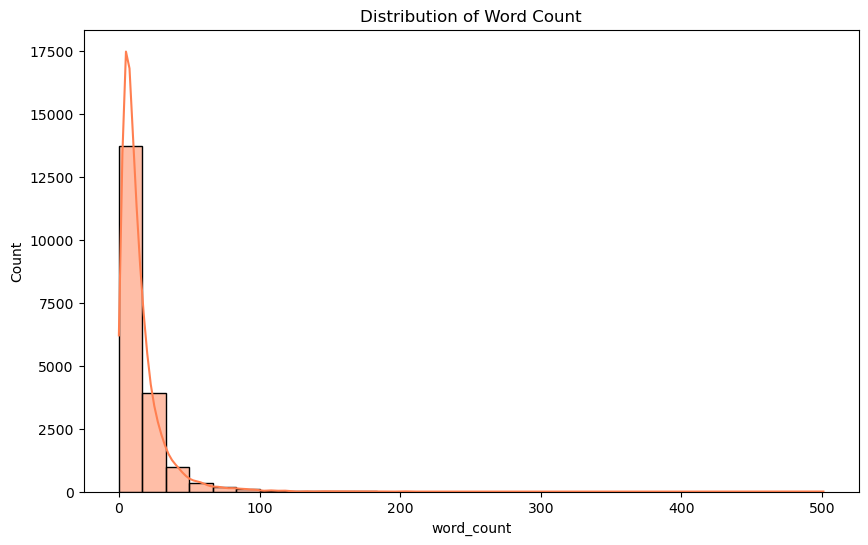

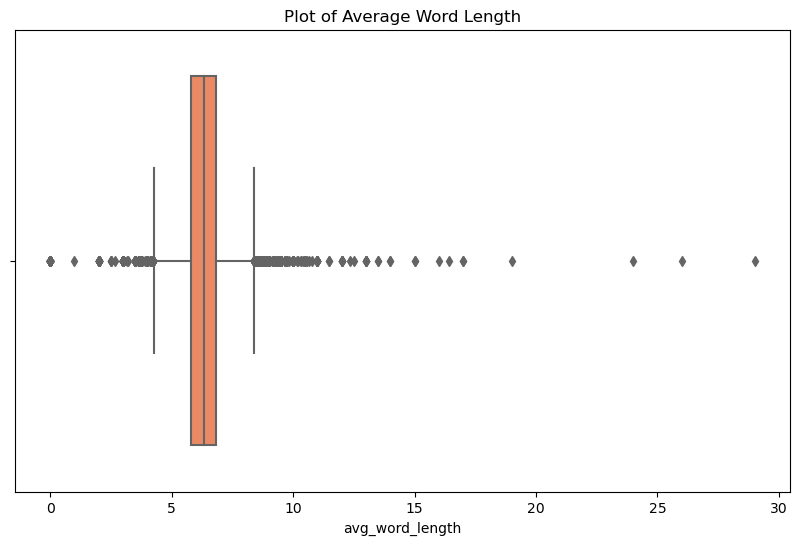

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='coral')
plt.title('Distribution of Word Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['avg_word_length'], color='coral')
plt.title('Plot of Average Word Length')
plt.show()

#### Findings
1. Distribution of word count shows most comments contain relatively few words and only a few comments with a very high word count
2. The central line in the box represents the median average of word length. Showing that there are some outliers skewed towards a high average word length.

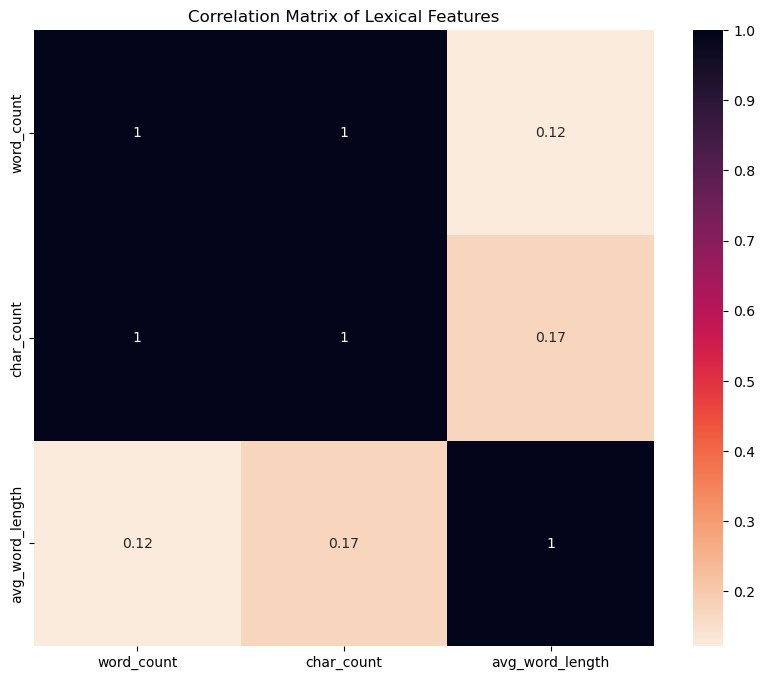

In [16]:
# Correlation matrix: Lexical Features
feature_cols = ['word_count', 'char_count', 'avg_word_length']
correlation_matrix = data[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')
plt.title('Correlation Matrix of Lexical Features')
plt.show()

#### Findings:
As expected character count is highly correlated with word count as more words will likely mean more characters. There is a weak correlation to the average word length. 

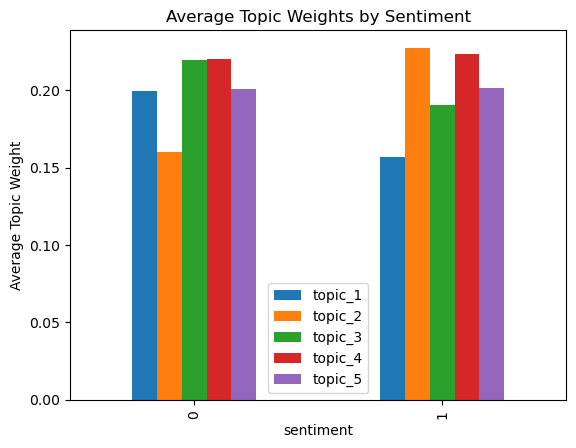

In [17]:
# DataFrame for the LDA topic distribution matrix
topics_df = pd.DataFrame(lda_features, columns=['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5'])

# Concatenate topic distribution with the original data
data_with_topics = pd.concat([data.reset_index(drop=True), topics_df], axis=1)

# Analyse distribution by sentiment
data_with_topics.groupby('sentiment')[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].mean().plot(kind='bar')
plt.title('Average Topic Weights by Sentiment')
plt.ylabel('Average Topic Weight')
plt.show()

#### Findings

Topic 3 more prevalent in harmful comments and less so for topic 2, 4 and 5. Topic 1 has a similar weight across the two classes.
***
# Split the Data

## Firstly, only with TF-IDF

In [18]:
target = data['sentiment'].values

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_features,
    target,  
    test_size=0.2,
    random_state=42,
    stratify=target
)

In [19]:
# Basic XGBoost model with TF-IDF
xgb_tfidf = xgb.XGBClassifier(max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict and evaluate
y_pred_tfidf = xgb_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3231
           1       0.99      0.59      0.74       626

    accuracy                           0.93      3857
   macro avg       0.96      0.79      0.85      3857
weighted avg       0.94      0.93      0.93      3857



# Split the Data
## With Combined Features

In [20]:
# Stack all features horizontally
combined_features = np.hstack((tfidf_features.toarray(), w2v_matrix, lexical_features, lda_features))

In [21]:
# Splitting the combined features
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    combined_features,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

In [22]:
# Basic XGBoost model with combined features
xgb_combined = xgb.XGBClassifier(max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_combined.fit(X_train_combined, y_train_combined)

# Predict and evaluate
y_pred_combined = xgb_combined.predict(X_test_combined)
print(classification_report(y_test_combined, y_pred_combined))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3231
           1       1.00      0.59      0.74       626

    accuracy                           0.93      3857
   macro avg       0.96      0.79      0.85      3857
weighted avg       0.94      0.93      0.93      3857



## Looking at feature importance

In [23]:
feature_importance_xgb = xgb_tfidf.feature_importances_
feature_names_xgb = tfidf_vectorizer.get_feature_names_out() 
features_xgb = sorted(zip(feature_importance_xgb, feature_names_xgb), reverse=True)

print("Top 10 important features for XGBoost:")
for importance, name in features_xgb[:10]:
    print(f"{name}: {importance:.4f}")

Top 10 important features for XGBoost:
shit: 0.1257
fucking: 0.1010
fuck: 0.0961
fucked: 0.0290
shite: 0.0255
cunt: 0.0228
piss: 0.0212
youre: 0.0145
maupay: 0.0084
absolute: 0.0083


### Findings: 
It's clear that profane words have a high feature importance in the better perfoming TF-IDF models. Therefore, it's a suitable next to look at using this further to create better features.
***
# Advanced NLP Techniques

## N-Grams

In [25]:
# Word-level TF-IDF
tfidf_vectorizer_words = TfidfVectorizer(max_features=1000, analyzer='word', ngram_range=(1,3))
tfidf_features_words = tfidf_vectorizer_words.fit_transform(data['clean_comment'])

# Character-level TF-IDF
tfidf_vectorizer_chars = TfidfVectorizer(max_features=1000, analyzer='char', ngram_range=(2,6))
tfidf_features_chars = tfidf_vectorizer_chars.fit_transform(data['clean_comment'])

In [26]:
# Get feature names for word-level TF-IDF
feature_names_words = tfidf_vectorizer_words.get_feature_names_out()

# Get feature names for character-level TF-IDF
feature_names_chars = tfidf_vectorizer_chars.get_feature_names_out()

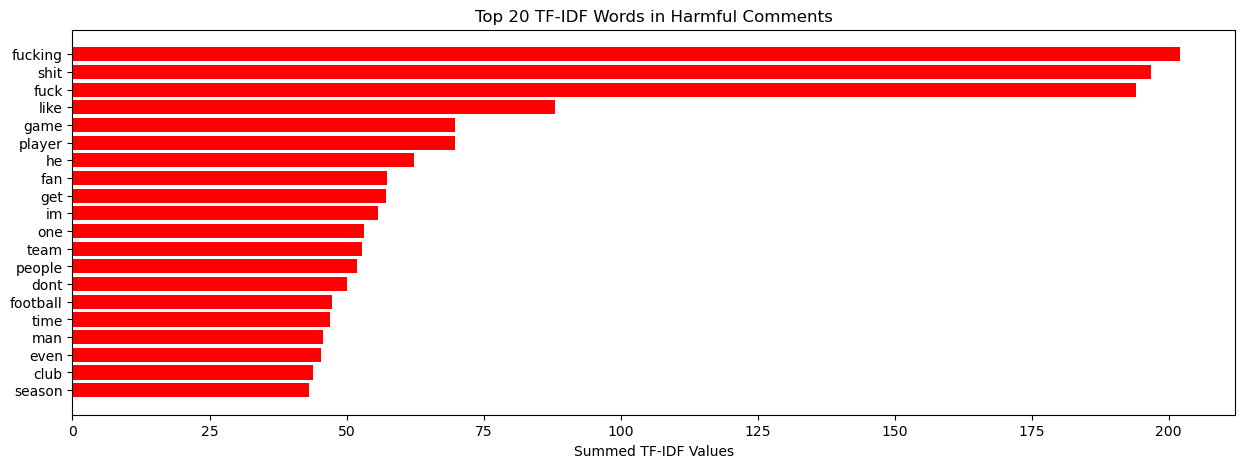

In [27]:
#Get indices for harmful comments
harmful_comments_idx = data[data['sentiment'] == 1].index

# Sum the TF-IDF scores for harmful comments
summed_tfidf_harmful = tfidf_features_words[harmful_comments_idx].sum(axis=0)

# Convert the summed scores to an array
summed_tfidf_harmful_array = np.array(summed_tfidf_harmful).flatten()

# Get feature names and indices of top N features
feature_names = tfidf_vectorizer_words.get_feature_names_out()
top_n = 20
sorted_indices_harmful = np.argsort(summed_tfidf_harmful_array)[-top_n:]

# Plot
plt.figure(figsize=(15, 5))
plt.barh(range(top_n), summed_tfidf_harmful_array[sorted_indices_harmful], color='red')
plt.yticks(range(top_n), [feature_names[i] for i in sorted_indices_harmful])
plt.title('Top 20 TF-IDF Words in Harmful Comments')
plt.xlabel('Summed TF-IDF Values')
plt.show()

***
## Creating a Profanity Count feature

In [28]:
# Extract all words from harmful and non-harmful comments
harmful_comments_words = ' '.join(data[data['sentiment'] == 1]['clean_comment']).split()
non_harmful_comments_words = ' '.join(data[data['sentiment'] == 0]['clean_comment']).split()

# Create frequency distributions
harmful_word_freq = Counter(harmful_comments_words)
non_harmful_word_freq = Counter(non_harmful_comments_words)

# Convert to dataframes for easier manipulation
harmful_df = pd.DataFrame(harmful_word_freq.items(), columns=['Word', 'Harmful_Freq'])
non_harmful_df = pd.DataFrame(non_harmful_word_freq.items(), columns=['Word', 'Non_Harmful_Freq'])

# Merge dataframes on the words
merged_df = pd.merge(harmful_df, non_harmful_df, on='Word', how='left')

# Fill NaN values with 0 - words that appear in harmful but not non-harmful comments
merged_df['Non_Harmful_Freq'] = merged_df['Non_Harmful_Freq'].fillna(0)

# Calculate and sort the difference in frequencies
merged_df['Freq_Difference'] = merged_df['Harmful_Freq'] - merged_df['Non_Harmful_Freq']
merged_df = merged_df.sort_values(by='Freq_Difference', ascending=False)

# Filter out words that are more frequent in non-harmful comments
profane_potential_words = merged_df[merged_df['Freq_Difference'] > 0]

# Show the top words that could potentially be profane
profane_potential_words.head(20)

,Word,Harmful_Freq,Non_Harmful_Freq,Freq_Difference
104,shit,714,0.0,714.0
28,fucking,585,0.0,585.0
78,fuck,512,0.0,512.0
1156,fucked,89,0.0,89.0
678,shite,80,0.0,80.0
56,cunt,80,0.0,80.0
59,piss,59,0.0,59.0
2111,shitty,34,0.0,34.0
2209,crap,32,0.0,32.0
1478,bullshit,29,0.0,29.0


In [29]:
# List of identified profane words
profane_words = [
    'shit', 'fucking', 'fuck', 'fucked', 'shite',
    'cunt', 'piss', 'shitty', 'crap', 'bullshit',
    'fucks', 'pissed', 'twat', 'dick', 'cunts',
    'holy', 'shitting', 'sex', 'bastard', 'wank'
]

# Count the occurrences of profane words
def count_profanity(text, profane_words):
    return sum(text.count(word) for word in profane_words)

data['profanity_count'] = data['clean_comment'].apply(lambda x: count_profanity(x, profane_words))

In [30]:
# Combine Profanity Count
profanity_features = data['profanity_count'].values.reshape(-1, 1)
profanity_features = csr_matrix(profanity_features.reshape(-1, 1))

***
# Splitting the data with the new features

In [31]:
new_features_matrix = hstack([tfidf_features_words, tfidf_features_chars, profanity_features])

In [32]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    new_features_matrix,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

In [33]:
# XGBoost model with new features
xgb_tfidf_new = xgb.XGBClassifier(max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_tfidf_new.fit(X_train_new, y_train_new)

# Predict and evaluate
y_pred_new = xgb_tfidf_new.predict(X_test_new)
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3231
           1       0.98      0.70      0.82       626

    accuracy                           0.95      3857
   macro avg       0.96      0.85      0.89      3857
weighted avg       0.95      0.95      0.95      3857



### Findings:
The model has significantly improved with the implementation of n-grams and the profanity count feature. I can now look at addressing the imbalance in the dataset. 
***
# Addressing the Imbalance in the Dataset
## SMOTE

In [34]:
# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_new, y_train_new)

In [35]:
# XGBoost model with the new features and SMOTE
xgb_smote = xgb.XGBClassifier(max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred_smote = xgb_smote.predict(X_test_new)
print(classification_report(y_test_new, y_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3231
           1       0.91      0.71      0.80       626

    accuracy                           0.94      3857
   macro avg       0.93      0.85      0.88      3857
weighted avg       0.94      0.94      0.94      3857



## Random Undersampling

In [36]:
# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_train_rus, y_train_rus = rus.fit_resample(X_train_new, y_train_new)

In [37]:
# XGBoost model with the new features and RUS
xgb_rus = xgb.XGBClassifier(max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_rus.fit(X_train_rus, y_train_rus)

# Predict and evaluate
y_pred_rus = xgb_rus.predict(X_test_new)
print(classification_report(y_test_new, y_pred_rus))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3231
           1       0.78      0.74      0.76       626

    accuracy                           0.92      3857
   macro avg       0.87      0.85      0.86      3857
weighted avg       0.92      0.92      0.92      3857



***
# GridSearch for XGBoost
#### Using no balancing technique

In [38]:
# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7, 1],
}

# Initialize the XGBoost model and the GridSearchCV object
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
grid_search_xg = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5),
    verbose=2
)

# Fit GridSearchCV
grid_search_xg.fit(X_train_new, y_train_new)


# Best model
print("Best parameters:", grid_search_xg.best_params_)

# Best model after grid search
best_xgb_model = grid_search_xg.best_estimator_
y_pred_ng = best_xgb_model.predict(X_test_new)
y_pred_grid_xg = grid_search_xg.predict(X_test_new)
print(classification_report(y_test_new, y_pred_grid_xg))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3231
           1       0.97      0.72      0.82       626

    accuracy                           0.95      3857
   macro avg       0.96      0.86      0.90      3857
weighted avg       0.95      0.95      0.95      3857



In [39]:
import joblib
joblib.dump((best_xgb_model, tfidf_vectorizer_words, tfidf_vectorizer_chars), 'xgb_model_and_vectorizers.pkl')

['xgb_model_and_vectorizers.pkl']